In [2]:
import pandas as pd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

In [3]:
# load dataset
df = pd.read_csv('data/train-data.csv')
df_test = pd.read_csv('data/test-data.csv')
df.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


In [5]:
# remove "Unnamed: 0" columns
df = df.iloc[:,1:]
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [6]:
df.describe()

,Year,Kilometers_Driven,Seats,Price
count,6019.000000,6.019000e+03,5977.000000,6019.000000
mean,2013.358199,5.873838e+04,5.278735,9.479468
std,3.269742,9.126884e+04,0.808840,11.187917
min,1998.000000,1.710000e+02,0.000000,0.440000
25%,2011.000000,3.400000e+04,5.000000,3.500000
50%,2014.000000,5.300000e+04,5.000000,5.640000
75%,2016.000000,7.300000e+04,5.000000,9.950000
max,2019.000000,6.500000e+06,10.000000,160.000000


In [7]:
df.shape

(6019, 13)

In [8]:
# drop Unnamed: 0 and New_Price
# df.drop(columns = ['Unnamed: 0','New_Price'], inplace = True)

In [9]:
# check for duplicated rows
# df.duplicated().sum()

In [10]:
# list unique values of categorical features (Location, Fuel_Type, Transmission, Owner_Type)
print(df['Location'].unique())
print(df['Fuel_Type'].unique())
print(df['Transmission'].unique())
print(df['Owner_Type'].unique())

['Mumbai' 'Pune' 'Chennai' 'Coimbatore' 'Hyderabad' 'Jaipur' 'Kochi'
 'Kolkata' 'Delhi' 'Bangalore' 'Ahmedabad']
['CNG' 'Diesel' 'Petrol' 'LPG' 'Electric']
['Manual' 'Automatic']
['First' 'Second' 'Fourth & Above' 'Third']


In [11]:
df.isnull().sum()

Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

In [12]:
# drop rows which contains NULL values
print("Shape of train data Before dropping any Row: ",df.shape)
df = df[df['Mileage'].notna()]
print("Shape of train data After dropping Rows with NULL values in Mileage: ",df.shape)
df = df[df['Engine'].notna()]
print("Shape of train data After dropping Rows with NULL values in Engine : ",df.shape)
df = df[df['Power'].notna()]
print("Shape of train data After dropping Rows with NULL values in Power  : ",df.shape)
df = df[df['Seats'].notna()]
print("Shape of train data After dropping Rows with NULL values in Seats  : ",df.shape)

Shape of train data Before dropping any Row:  (6019, 13)
Shape of train data After dropping Rows with NULL values in Mileage:  (6017, 13)
Shape of train data After dropping Rows with NULL values in Engine :  (5981, 13)
Shape of train data After dropping Rows with NULL values in Power  :  (5981, 13)
Shape of train data After dropping Rows with NULL values in Seats  :  (5975, 13)


In [13]:
# after using .notna() we have many absent indexes 
# (Eg: If row no 47 was droped then after 46 we have 48 index), 
# so reset the index and droping the present index
df = df.reset_index(drop=True)

In [14]:
# extracting data
for i in range(df.shape[0]):
    df.at[i, 'Company'] = df['Name'][i].split()[0]
    df.at[i, 'Mileage(km/kg)'] = str(df['Mileage'][i]).split()[0]
    df.at[i, 'Engine(CC)'] = df['Engine'][i].split()[0]
    df.at[i, 'Power(bhp)'] = df['Power'][i].split()[0]

In [15]:
df['Mileage(km/kg)'] = df['Mileage(km/kg)'].astype(float)
df['Engine(CC)'] = df['Engine(CC)'].astype(float)

In [16]:
# change Power(bhp) to float an error occured (Can't convert str to float : null). 
# so, found some cell where having values: 'null bhp'
x = 'n'
count = 0
position = []
for i in range(df.shape[0]):
    if df['Power(bhp)'][i]=='null':
        x = 'Y'
        count = count + 1
        position.append(i)
print(x)
print(count)
print(position)

Y
103
[76, 79, 89, 120, 143, 225, 242, 259, 304, 305, 383, 421, 425, 440, 469, 572, 628, 644, 645, 735, 744, 824, 910, 921, 929, 1063, 1138, 1148, 1266, 1313, 1338, 1380, 1411, 1546, 1569, 1640, 1663, 1848, 1989, 2043, 2118, 2152, 2250, 2254, 2292, 2328, 2377, 2425, 2434, 2481, 2485, 2511, 2561, 2579, 2616, 2621, 2868, 3010, 3038, 3081, 3166, 3224, 3266, 3414, 3491, 3506, 3562, 3601, 3611, 3618, 3642, 3706, 3868, 3900, 3969, 4046, 4049, 4318, 4321, 4593, 4672, 4676, 4706, 4792, 4848, 4862, 4914, 5024, 5078, 5186, 5383, 5395, 5415, 5486, 5490, 5604, 5712, 5716, 5818, 5830, 5881, 5899, 5941]


In [17]:
df = df.drop(df.index[position])
df = df.reset_index(drop=True)

In [18]:
df['Power(bhp)'] = df['Power(bhp)'].astype(float)

In [19]:
df.head()

,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price,Company,Mileage(km/kg),Engine(CC),Power(bhp)
0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75,Maruti,26.60,998.0,58.16
1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50,Hyundai,19.67,1582.0,126.20
2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50,Honda,18.20,1199.0,88.70
3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00,Maruti,20.77,1248.0,88.76
4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74,Audi,15.20,1968.0,140.80


In [20]:
for i in range(df.shape[0]):
    if pd.isnull(df.loc[i,'New_Price']) == False:
        df.at[i,'New_car_Price'] = df['New_Price'][i].split()[0]

In [21]:
df['New_car_Price'] = df['New_car_Price'].astype(float)

In [22]:
# delete columns
df.drop(["Name"],axis=1,inplace=True)
df.drop(["Mileage"],axis=1,inplace=True)
df.drop(["Engine"],axis=1,inplace=True)
df.drop(["Power"],axis=1,inplace=True)
df.drop(["New_Price"],axis=1,inplace=True)

In [23]:
## data vis

# price
df['Price'].describe()

count    5872.000000
mean        9.603919
std        11.249453
min         0.440000
25%         3.517500
50%         5.750000
75%        10.000000
max       160.000000
Name: Price, dtype: float64

(0.0, 160.0)

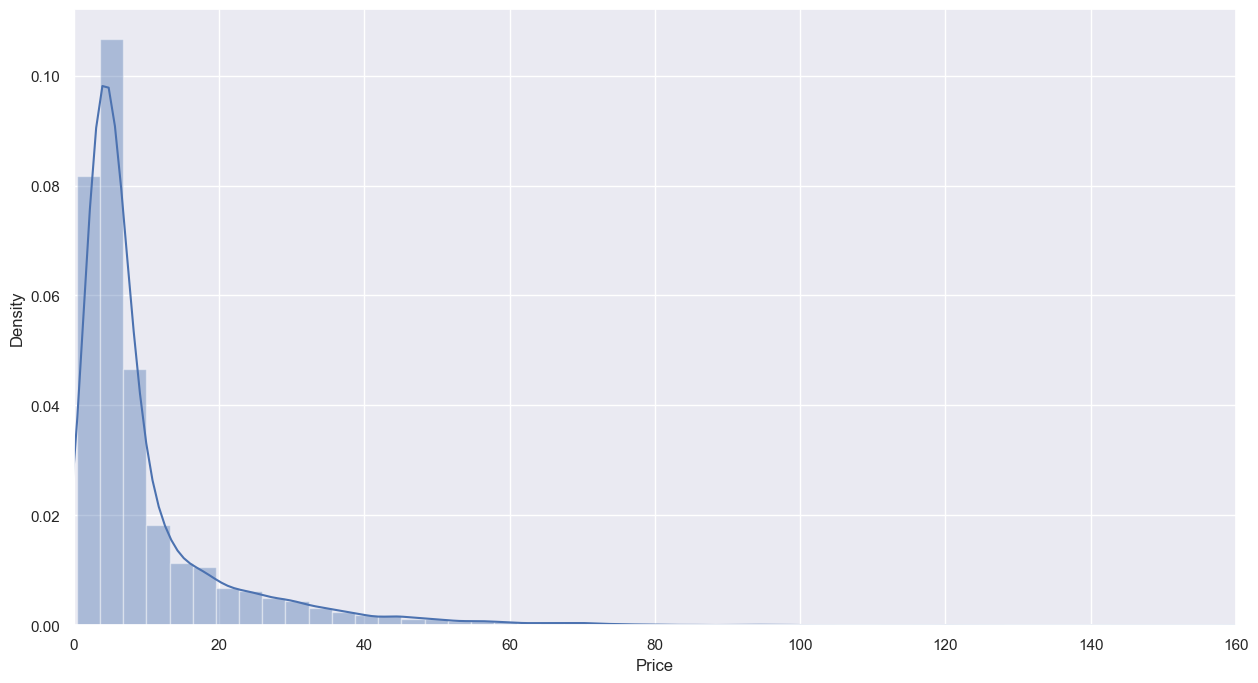

In [24]:
f, ax = plt.subplots(figsize=(15,8))
sns.distplot(df['Price'])
plt.xlim([0,160])

In [25]:
# fuel type
df['Fuel_Type'].describe()

count       5872
unique         4
top       Diesel
freq        3152
Name: Fuel_Type, dtype: object

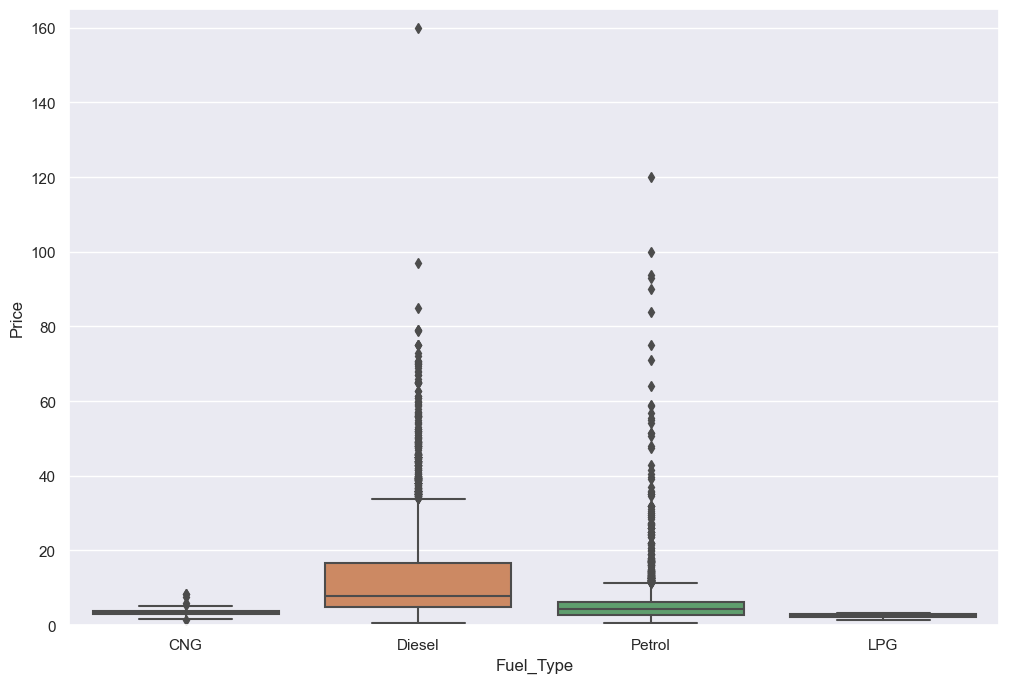

In [26]:
var = 'Fuel_Type'
data = pd.concat([df['Price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin=0, ymax=165);

<AxesSubplot:xlabel='Fuel_Type', ylabel='Price'>

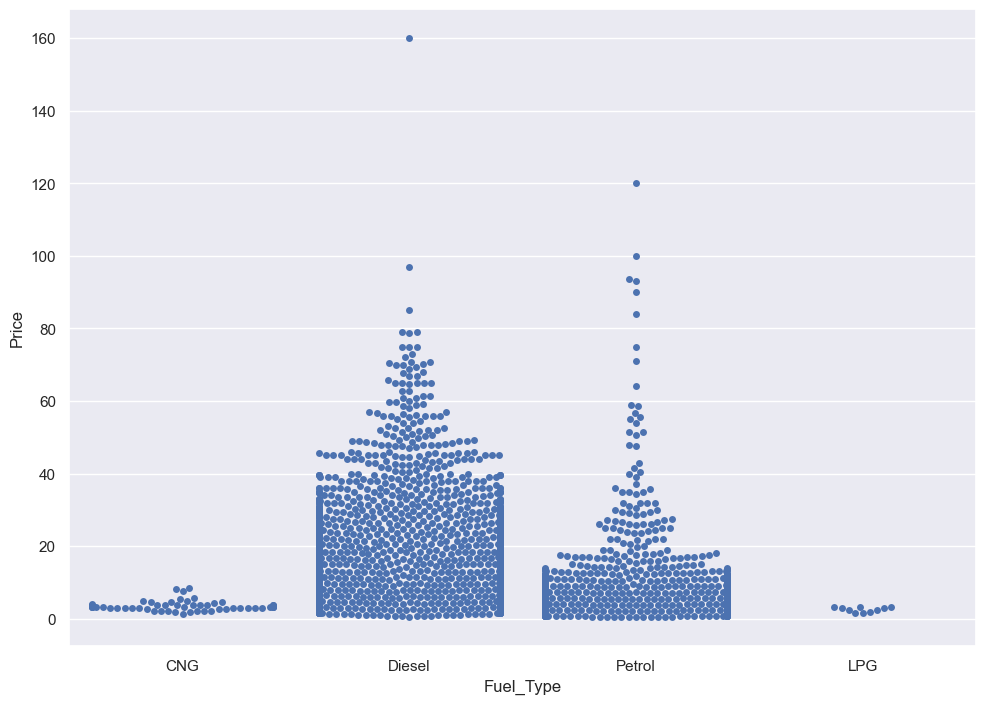

In [27]:
var = 'Fuel_Type'
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.swarmplot(x = var, y ='Price', data = df)

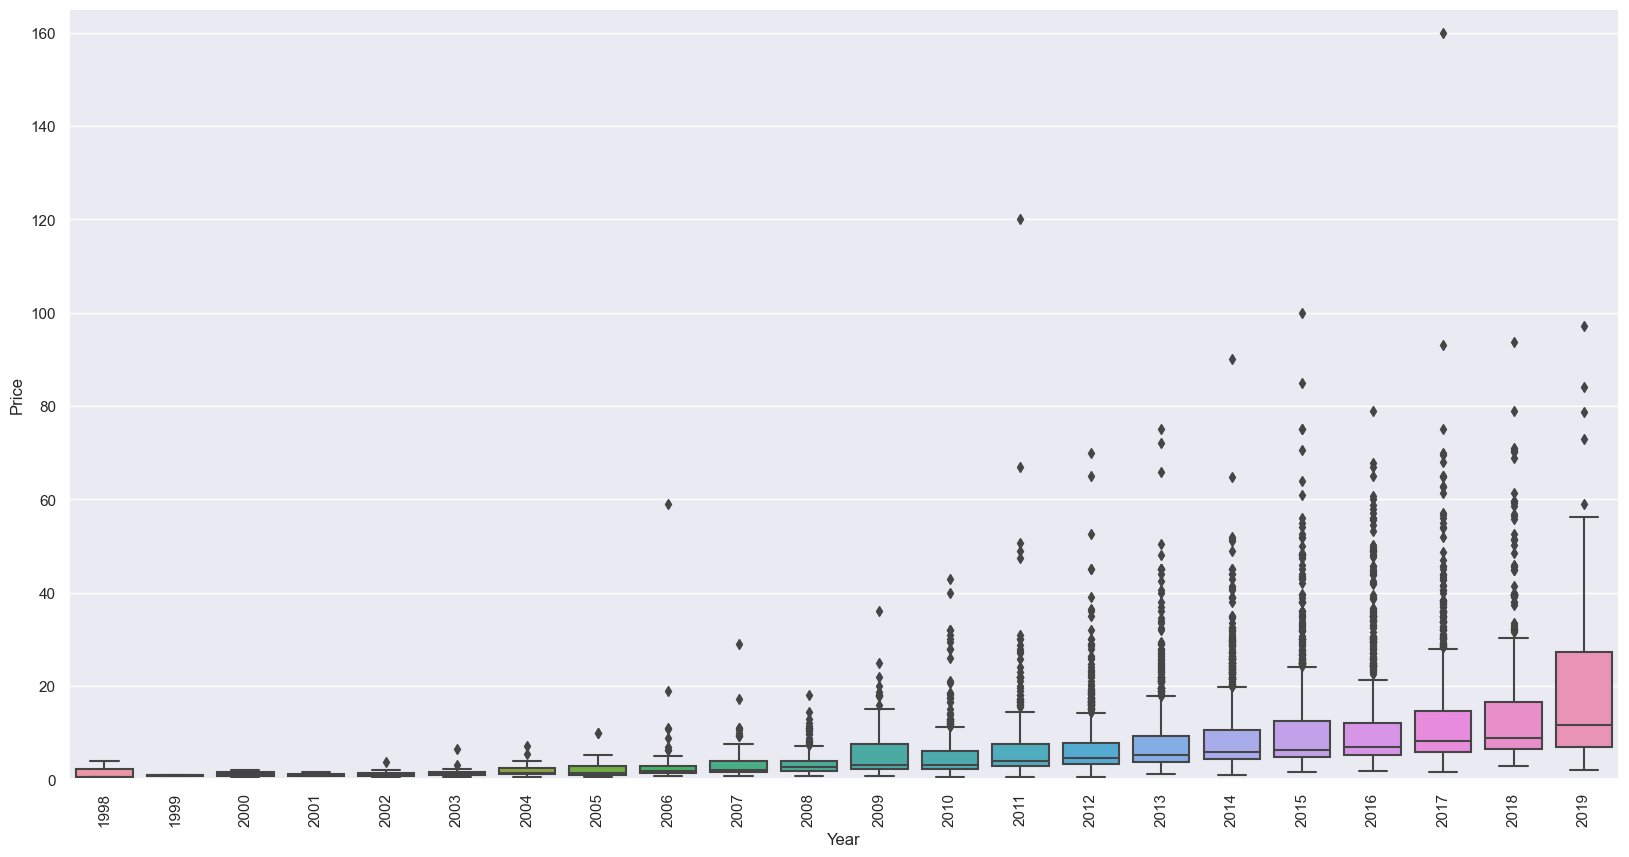

In [28]:
# year
var = 'Year'
data = pd.concat([df['Price'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(20, 10))
fig = sns.boxplot(x=var, y="Price", data=data)
fig.axis(ymin=0, ymax=165);
plt.xticks(rotation=90);

<AxesSubplot:xlabel='Owner_Type', ylabel='Price'>

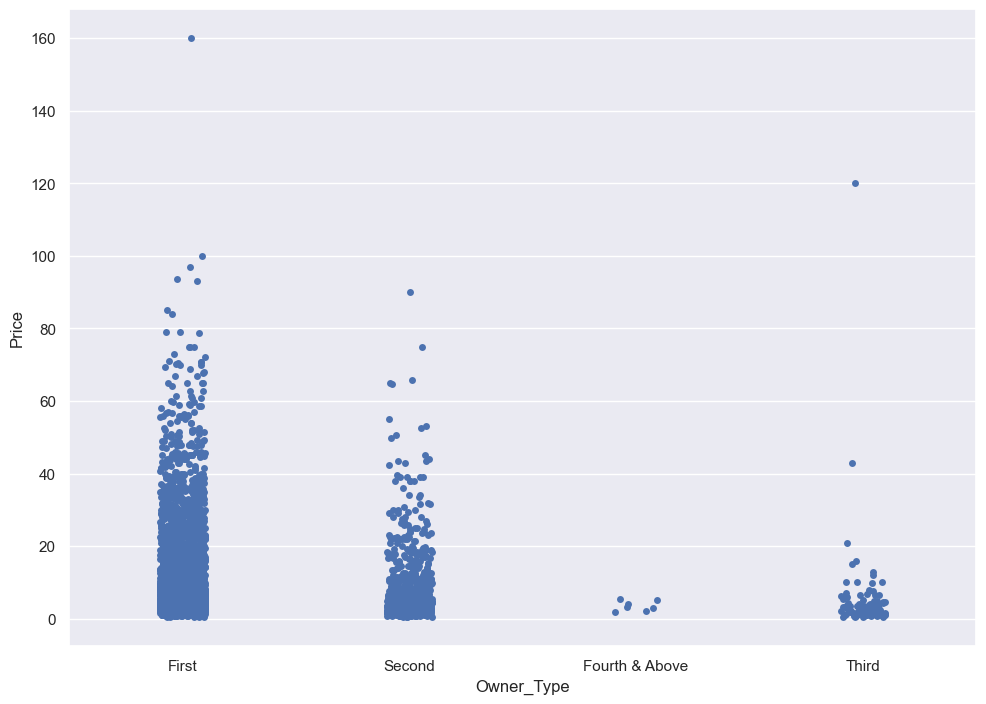

In [29]:
var = 'Owner_Type'
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)
sns.stripplot(x = var, y ='Price', data = df) 

<Figure size 2000x1000 with 0 Axes>

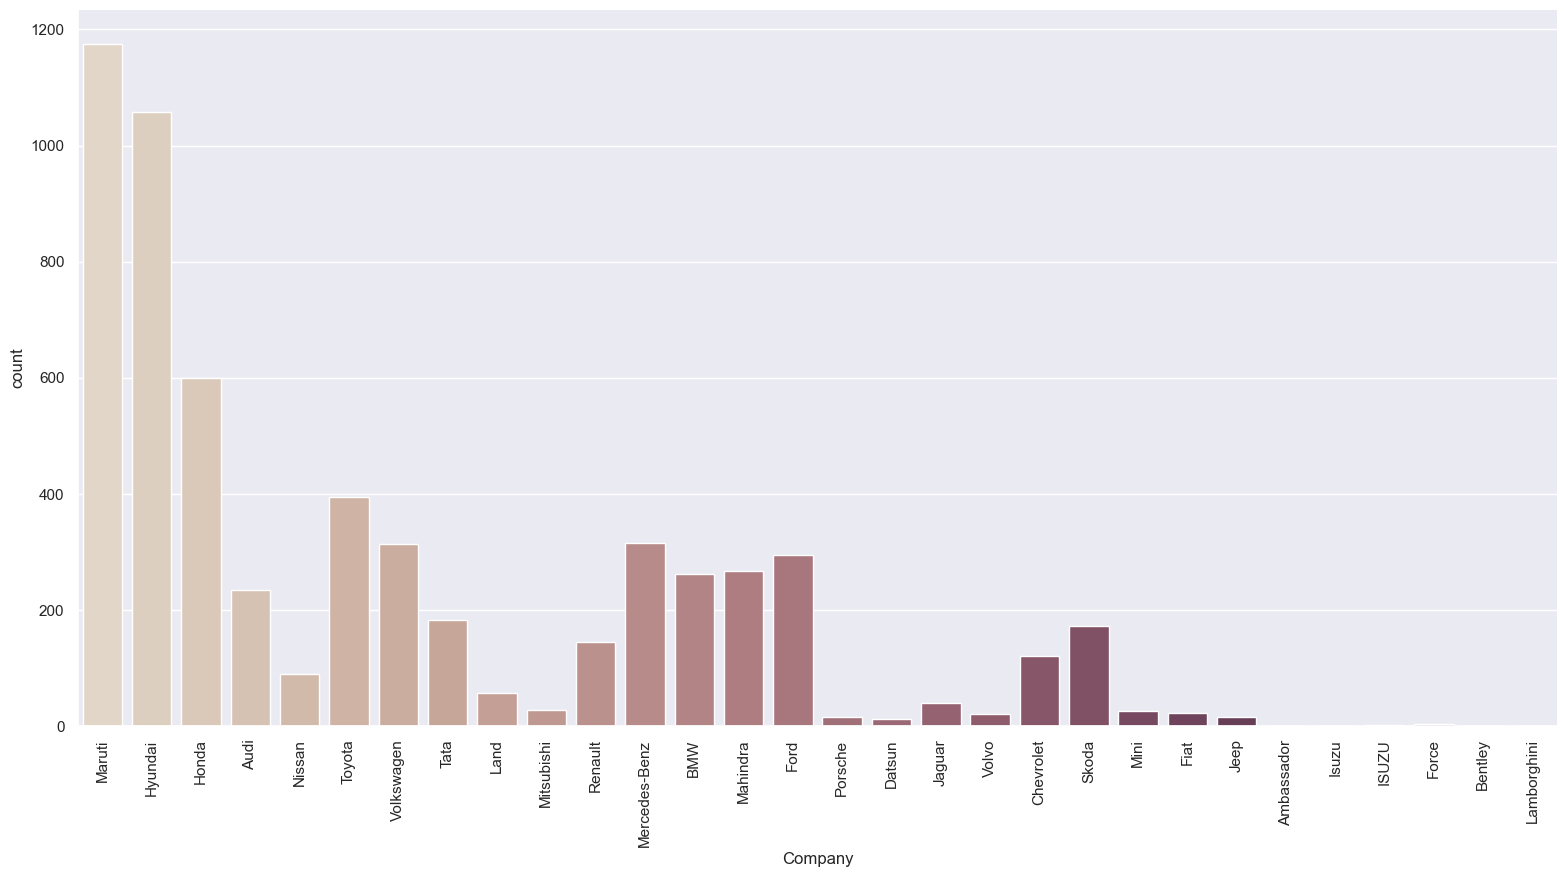

In [30]:
# company
var = "Company"
plt.figure(figsize=(20, 10))
sns.catplot(x=var, kind="count", palette="ch:.25", height=8, aspect=2, data=df);
plt.xticks(rotation=90);

In [31]:
# working with categorical data

# 5 categorical features (Location, Fuel_Type, Transmission, Owner_Type, Company)
# using 1 of 2 approaches
# OneHotEncoder when order does NOT matter and LabelEncoder when order matters

# Location
var = 'Location'
df[var].value_counts()

Mumbai        775
Hyderabad     718
Kochi         645
Coimbatore    629
Pune          594
Delhi         545
Kolkata       521
Chennai       476
Jaipur        402
Bangalore     347
Ahmedabad     220
Name: Location, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

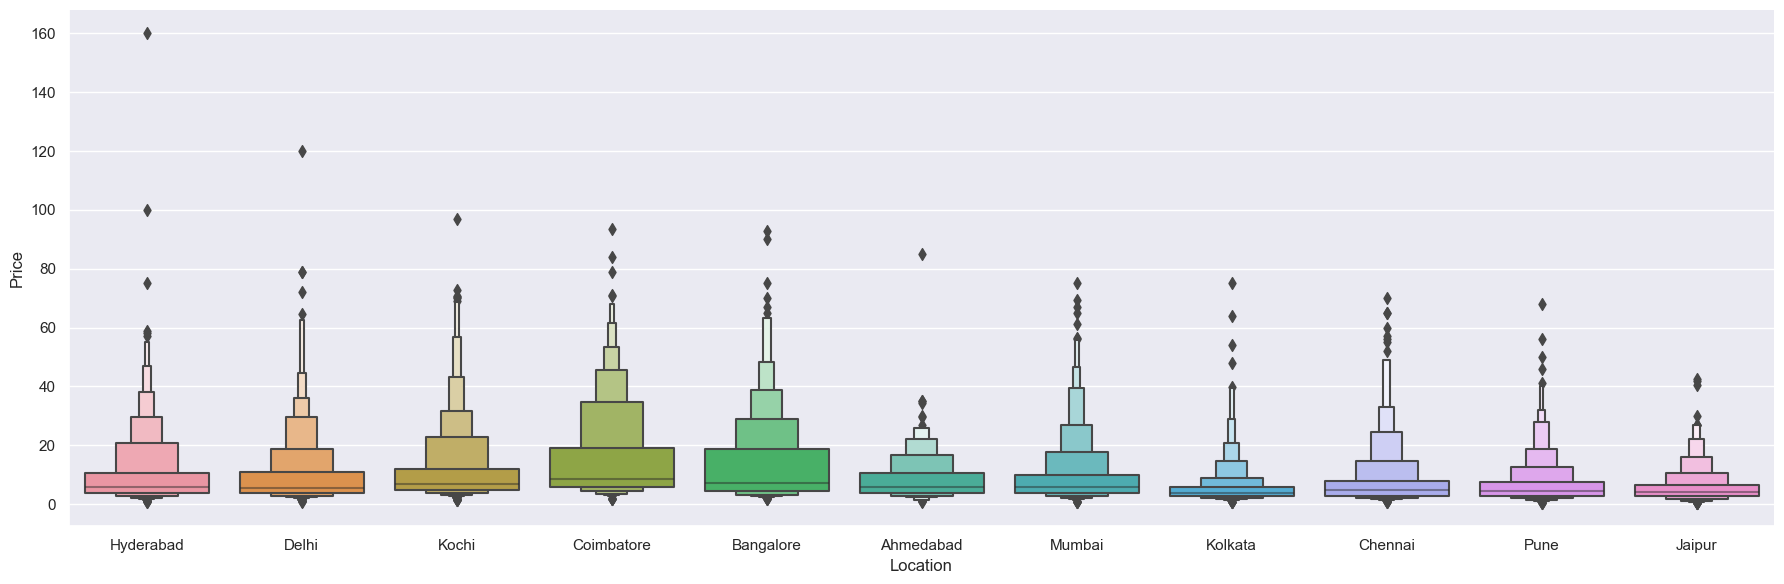

In [32]:
# Location vs Price
sns.catplot(y='Price',x=var,data= df.sort_values('Price',ascending=False),\
            kind="boxen",height=6, aspect=3)
plt.show

In [33]:
# using 1 hot encoding
Location = df[[var]]
Location = pd.get_dummies(Location, drop_first=True)
Location.head()

,Location_Bangalore,Location_Chennai,Location_Coimbatore,Location_Delhi,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune
0,0,0,0,0,0,0,0,0,1,0
1,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


In [34]:
# Fuel Type
var = 'Fuel_Type'
df[var].value_counts()

Diesel    3152
Petrol    2655
CNG         55
LPG         10
Name: Fuel_Type, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

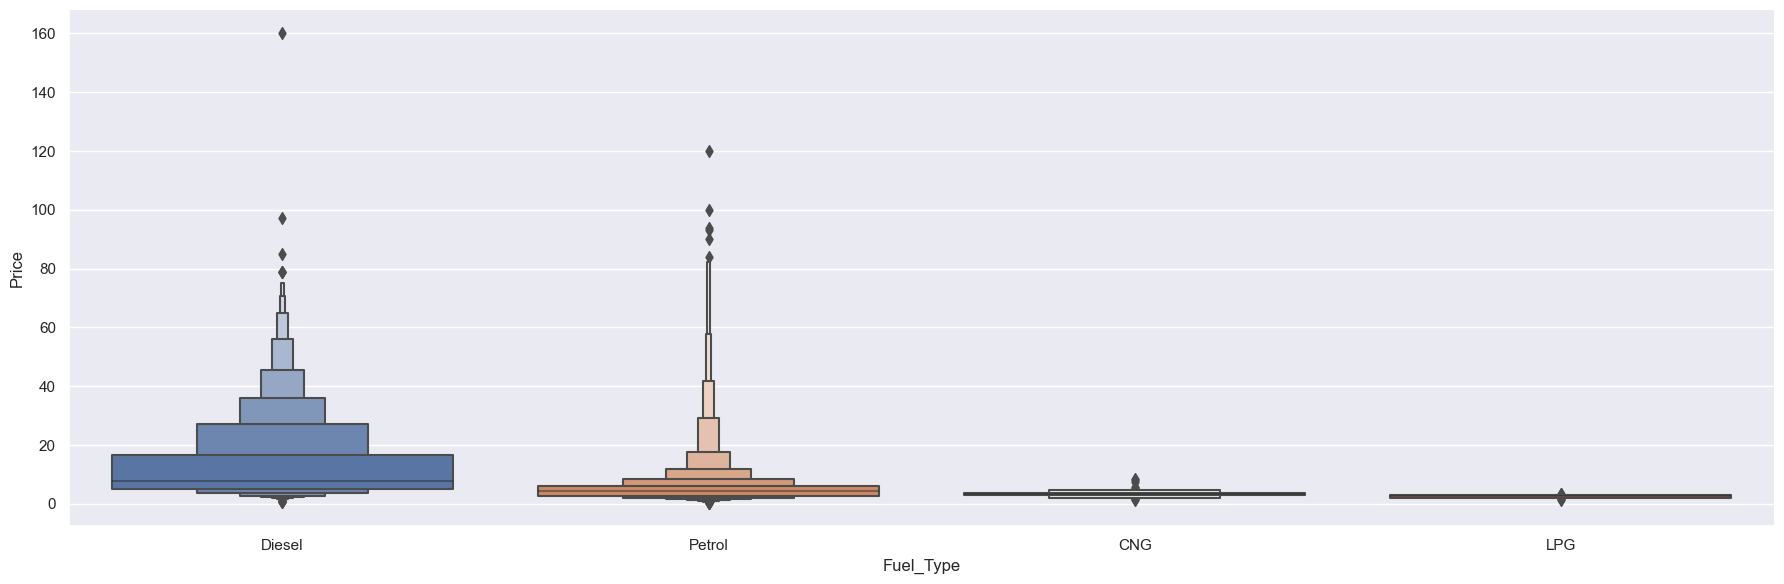

In [35]:
# Fuel_Type vs Price
sns.catplot(y='Price', x=var, data=df.sort_values('Price',ascending=False),\
            kind="boxen",height=6, aspect=3)
plt.show

In [36]:
# using 1 hot encoding
Fuel_Type = df[[var]]
Fuel_Type = pd.get_dummies(Fuel_Type, drop_first=True)
Fuel_Type.head()

,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol
0,0,0,0
1,1,0,0
2,0,0,1
3,1,0,0
4,1,0,0


In [37]:
# Transmission
var = 'Transmission'
df[var].value_counts()

Manual       4170
Automatic    1702
Name: Transmission, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

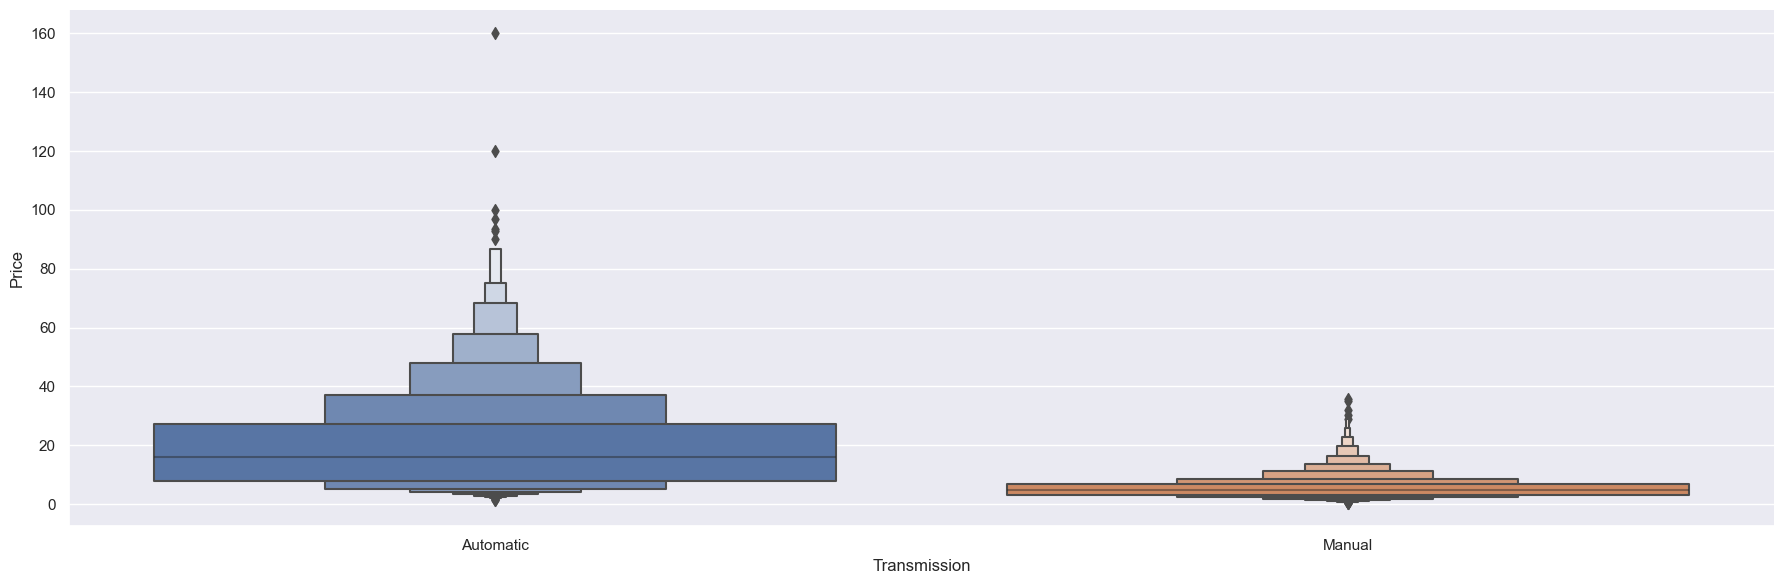

In [38]:
# Transmission vs Price
sns.catplot(y='Price', x=var, data=df.sort_values('Price',ascending=False),\
            kind="boxen",height=6, aspect=3)
plt.show

In [39]:
# using 1 hot encoding
Transmission = df[[var]]
Transmission = pd.get_dummies(Transmission,drop_first=True)
Transmission.head()

,Transmission_Manual
0,1
1,1
2,1
3,1
4,0


In [40]:
# Owner_Type
var = 'Owner_Type'
df[var].value_counts()

First             4839
Second             925
Third              101
Fourth & Above       7
Name: Owner_Type, dtype: int64

In [41]:
# Owner_Type column has ordered data so, using Label Encoding
df.replace({"First":1,"Second":2,"Third": 3,"Fourth & Above":4},inplace=True)
df.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price,Company,Mileage(km/kg),Engine(CC),Power(bhp),New_car_Price
0,Mumbai,2010,72000,CNG,Manual,1,5.0,1.75,Maruti,26.60,998.0,58.16,NaN
1,Pune,2015,41000,Diesel,Manual,1,5.0,12.50,Hyundai,19.67,1582.0,126.20,NaN
2,Chennai,2011,46000,Petrol,Manual,1,5.0,4.50,Honda,18.20,1199.0,88.70,8.61
3,Chennai,2012,87000,Diesel,Manual,1,7.0,6.00,Maruti,20.77,1248.0,88.76,NaN
4,Coimbatore,2013,40670,Diesel,Automatic,2,5.0,17.74,Audi,15.20,1968.0,140.80,NaN


In [42]:
# Company
var = 'Company'
df[var].value_counts()

Maruti           1175
Hyundai          1058
Honda             600
Toyota            394
Mercedes-Benz     316
Volkswagen        314
Ford              294
Mahindra          268
BMW               262
Audi              235
Tata              183
Skoda             172
Renault           145
Chevrolet         120
Nissan             89
Land               57
Jaguar             40
Mitsubishi         27
Mini               26
Fiat               23
Volvo              21
Porsche            16
Jeep               15
Datsun             13
Force               3
ISUZU               2
Ambassador          1
Isuzu               1
Bentley             1
Lamborghini         1
Name: Company, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

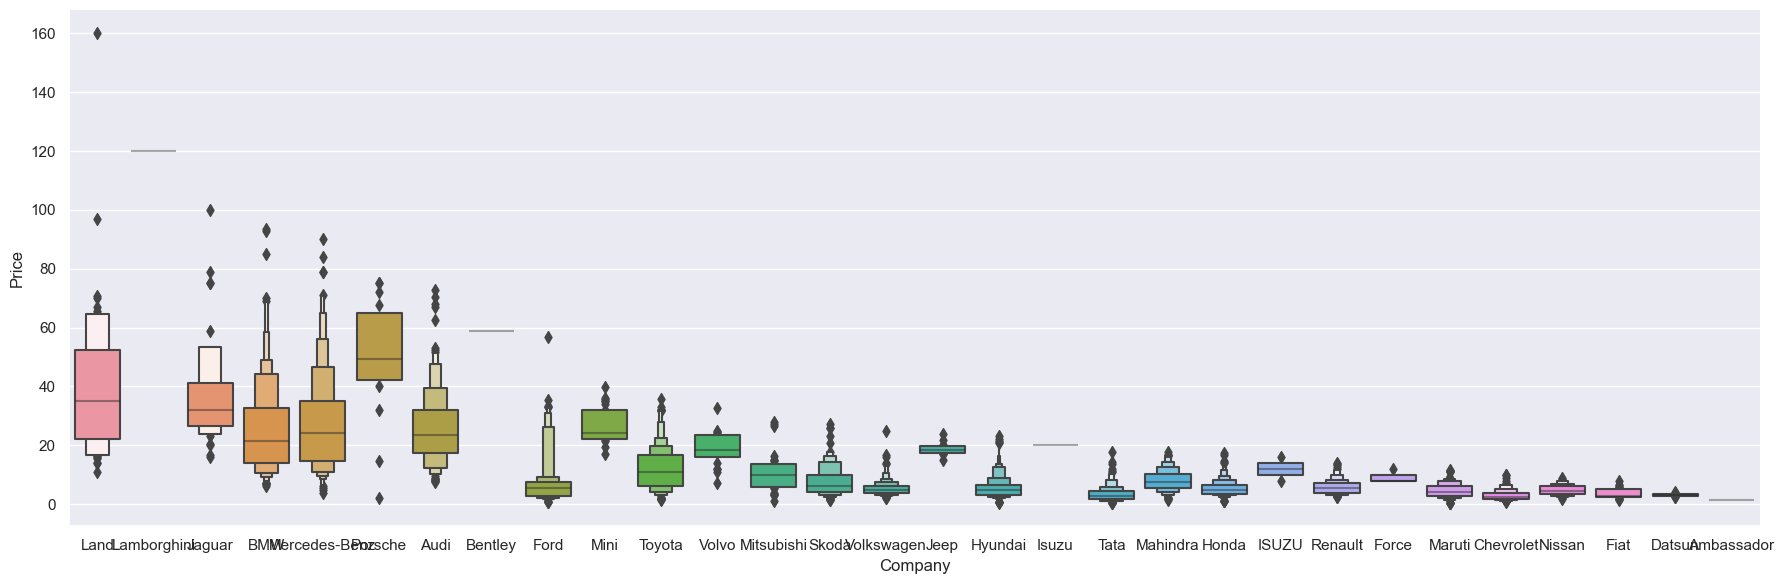

In [43]:
# Company vs Price
sns.catplot(y='Price',x=var,data= df.sort_values('Price',ascending=False),\
            kind="boxen",height=6, aspect=3)
plt.show

In [44]:
# it has a lot of variation so, drop it
df.drop(["Company"],axis=1,inplace=True)

In [45]:
# combine all data frames
final_train= pd.concat([df,Location,Fuel_Type,Transmission], axis=1)
final_train.head()

,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price,Mileage(km/kg),Engine(CC),...,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual
0,Mumbai,2010,72000,CNG,Manual,1,5.0,1.75,26.60,998.0,...,0,0,0,0,1,0,0,0,0,1
1,Pune,2015,41000,Diesel,Manual,1,5.0,12.50,19.67,1582.0,...,0,0,0,0,0,1,1,0,0,1
2,Chennai,2011,46000,Petrol,Manual,1,5.0,4.50,18.20,1199.0,...,0,0,0,0,0,0,0,0,1,1
3,Chennai,2012,87000,Diesel,Manual,1,7.0,6.00,20.77,1248.0,...,0,0,0,0,0,0,1,0,0,1
4,Coimbatore,2013,40670,Diesel,Automatic,2,5.0,17.74,15.20,1968.0,...,0,0,0,0,0,0,1,0,0,0


In [46]:
# drop the original column (Location, Fuel_Type, Transmission) plus New_car_Price
cols_to_remove = ["Location","Fuel_Type","Transmission","New_car_Price"]
final_train.drop(cols_to_remove,axis=1,inplace=True)
final_train.head()

,Year,Kilometers_Driven,Owner_Type,Seats,Price,Mileage(km/kg),Engine(CC),Power(bhp),Location_Bangalore,Location_Chennai,...,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual
0,2010,72000,1,5.0,1.75,26.60,998.0,58.16,0,0,...,0,0,0,0,1,0,0,0,0,1
1,2015,41000,1,5.0,12.50,19.67,1582.0,126.20,0,0,...,0,0,0,0,0,1,1,0,0,1
2,2011,46000,1,5.0,4.50,18.20,1199.0,88.70,0,1,...,0,0,0,0,0,0,0,0,1,1
3,2012,87000,1,7.0,6.00,20.77,1248.0,88.76,0,1,...,0,0,0,0,0,0,1,0,0,1
4,2013,40670,2,5.0,17.74,15.20,1968.0,140.80,0,0,...,0,0,0,0,0,0,1,0,0,0


In [47]:
# preparing test data
final_train.shape

(5872, 22)

In [48]:
df_test = df_test.iloc[:,1:]

In [49]:
df_test.columns

Index(['Name', 'Location', 'Year', 'Kilometers_Driven', 'Fuel_Type',
       'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power', 'Seats',
       'New_Price'],
      dtype='object')

In [50]:
print("Shape of test data Before dropping any Row: ",df.shape)
df_test = df_test[df_test['Mileage(km/kg)'].notna()]
print("Shape of test data After dropping Rows with NULL values in Mileage: ",df_test.shape)
df_test = df_test[df_test['Engine(CC)'].notna()]
print("Shape of test data After dropping Rows with NULL values in Engine : ",df_test.shape)
df_test = df_test[df_test['Power(bhp)'].notna()]
print("Shape of test data After dropping Rows with NULL values in Power  : ",df_test.shape)
df_test = df_test[df_test['Seats'].notna()]
print("Shape of test data After dropping Rows with NULL values in Seats  : ",df_test.shape)
print('Droping null done')

Shape of test data Before dropping any Row:  (5872, 12)


KeyError: 'Mileage(km/kg)'

In [51]:
df_test = df_test.reset_index(drop=True)
print('Index reset done')

Index reset done


In [52]:
for i in range(df_test.shape[0]):
    df_test.at[i, 'Mileage(km/kg)'] = str(df_test['Mileage(km/kg)'][i]).split()[0]
    df_test.at[i, 'Engine(CC)'] = str(df_test['Engine(CC)'][i]).split()[0]
    df_test.at[i, 'Power(bhp)'] = str(df_test['Power(bhp)'][i]).split()[0]
print('Split Done')

KeyError: 'Mileage(km/kg)'

In [ ]:
df_test['Mileage(km/kg)'] = df_test['Mileage(km/kg)'].astype(float)
df_test['Engine(CC)'] = df_test['Engine(CC)'].astype(float)
print('casting 1 Done') 

In [ ]:
position = []
for i in range(df_test.shape[0]):
    if df_test['Power(bhp)'][i]=='null':
        position.append(i)
        
df_test = df_test.drop(df_test.index[position])
df_test = df_test.reset_index(drop=True) 

df_test['Power(bhp)'] = df_test['Power(bhp)'].astype(float)
print('casting 2 Done')

In [ ]:
for i in range(df_test.shape[0]):
    if pd.isnull(df_test.loc[i,'New_car_Price']) == False:
        df_test.at[i,'New_car_Price'] = str(df_test['New_car_Price'][i]).split()[0]

In [ ]:
df_test['New_car_Price'] = df_test['New_car_Price'].astype(float)

In [ ]:
df_test.head(2)

In [ ]:
# df_test.drop(["Mileage"],axis=1,inplace=True)
# df_test.drop(["Engine"],axis=1,inplace=True)
# df_test.drop(["Power"],axis=1,inplace=True)
# df_test.drop(["New_Price"],axis=1,inplace=True)

In [ ]:
# var = 'Location'
# Location = df_test[[var]]
# Location = pd.get_dummies(Location,drop_first=True)
# Location.head()

In [ ]:
var = 'Fuel_Type'
Fuel_t = df_test[[var]]
Fuel_t = pd.get_dummies(Fuel_t,drop_first=True)
Fuel_t.head()

In [ ]:
var = 'Transmission'
Transmission = df_test[[var]]
Transmission = pd.get_dummies(Transmission,drop_first=True)
Transmission.head()

In [ ]:
df_test.replace({"First":1,"Second":2,"Third": 3,"Fourth & Above":4},inplace=True)
df_test.head()

In [ ]:
final_test= pd.concat([df_test,Fuel_t,Transmission],axis=1)
final_test.head()

In [ ]:
final_test.head()

In [ ]:
final_test.drop(["Fuel_Type","Transmission","New_car_Price"],axis=1,inplace=True)
final_test.head()

In [ ]:
print("Final Test Size: ",final_test.shape)

In [ ]:
final_train.columns

In [ ]:
X = final_train.loc[:,['Year', 'Kilometers_Driven', 'Owner_Type', 'Seats',
       'Mileage(km/kg)', 'Engine(CC)', 'Power(bhp)', 
       'Location_Bangalore', 'Location_Chennai', 'Location_Coimbatore',
       'Location_Delhi', 'Location_Hyderabad', 'Location_Jaipur',
       'Location_Kochi', 'Location_Kolkata', 'Location_Mumbai',
       'Location_Pune', 'Fuel_Type_Diesel', 'Fuel_Type_LPG',
       'Fuel_Type_Petrol', 'Transmission_Manual']]
X.shape

In [ ]:
y = final_train.loc[:,['Price']]
y.head()

### Correlation Analysis

In [ ]:
final_train.corr()['Price']

In [ ]:
# feature heatmap
plt.figure(figsize=(18,18))
sns.heatmap(final_train.corr(),annot=True,cmap='RdYlGn')

plt.show()

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor
selection= ExtraTreesRegressor()
selection.fit(X,y)

In [ ]:
# vis feature importances for better visualization

plt.figure(figsize = (12,8))
feat_importances = pd.Series(selection.feature_importances_, index=X.columns)
feat_importances.nlargest(20).plot(kind='barh')
plt.show()

In [ ]:
# model building
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 25)

In [ ]:
# linear regression
from sklearn.linear_model import LinearRegression
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
y_pred= linear_reg.predict(X_test)
print("Accuracy on Traing set: ",linear_reg.score(X_train,y_train))
print("Accuracy on Testing set: ",linear_reg.score(X_test,y_test))

In [ ]:
# random forest
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
y_pred= rf_reg.predict(X_test)
print("Accuracy on Traing set: ",rf_reg.score(X_train,y_train))
print("Accuracy on Testing set: ",rf_reg.score(X_test,y_test))

In [ ]:
import numpy as np
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error

print("\t\tError Table")
print('Mean Absolute Error      : ', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared  Error      : ', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared  Error : ', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R Squared Error          : ', metrics.r2_score(y_test, y_pred))

In [ ]:
# # removing outlier
# for col in ['Engine','Power','Kilometers_Driven','Mileage','Price']:
#     Q1 = df[col].quantile(0.25)
#     Q3 = df[col].quantile(0.75)
#     IQR = Q3 - Q1
#     lower_bound = Q1 - 2.5*IQR
#     upper_bound = Q3 + 2.5*IQR
#     df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [ ]:
# df['Name'].nunique()

In [ ]:
# df['Company'] = df['Name'].str.split(expand=True)[0].str.lower()
# df['Model'] = df['Name'].str.split().str[0:2].str.join(' ').str.lower()
# df.drop(columns = ['Name'], inplace = True)

In [ ]:
# df['Company'].nunique() , df['Model'].nunique()

In [ ]:
# univariate analysis

# # make the data fall in certain range.
# def remove_outliers(df, col, lower, upper):
#     df = df[ (df[col]>lower) & (df[col]<upper) ]
#     return df

In [ ]:
# ploting histogram & boxplot for col parameter
# def plot_num(df, col):
#     fig ,ax = plt.subplots(1,2,figsize=(16,4))
#     sns.histplot(df,x=col,kde=True,ax=ax[0])
#     sns.boxplot(df,x=col,ax=ax[1])
#     ax[0].set_title(f'Distribution of {col}')
#     ax[1].set_title(f'{col} Boxplot')
#     fig.show();

In [ ]:
# year
# plt.figure(figsize=(15,5))
# sns.countplot(df,x='Year');
# plt.title('Distribution of Year Column');

In [ ]:
# # kilometers driven
# plot_num(df,'Kilometers_Driven')

In [ ]:
# # fuel type
# plt.figure(figsize=(8,4))
# sns.countplot(df,x='Fuel_Type');
# plt.title('Distribution of Fuel_Type');

In [ ]:
# df['Fuel_Type'].value_counts()

In [ ]:
# # exclude Fuel_Types with low frequency from the dataset
# df = df[~df['Fuel_Type'].isin(['LPG','Electric'])]

In [ ]:
# # transmission
# plt.figure(figsize=(8,4))
# sns.countplot(df,x='Transmission');
# plt.title('Distribution of Transmission');

In [ ]:
# df['Transmission'].value_counts()

In [ ]:
# owner type
# plt.figure(figsize=(8,4))
# sns.countplot(df,x='Owner_Type');
# plt.title('Distribution of Owner_Type');

In [ ]:
# # endcode owener type
# df['Owner_Type'] = df['Owner_Type'].map({"First":3,"Second":2,"Third":1,"Fourth & Above":0})

In [ ]:
# # mileage
# plot_num(df,'Mileage')

In [ ]:
# # engine
# plot_num(df,'Engine')

In [ ]:
# # power
# plot_num(df,'Power')

In [ ]:
# # seats
# plt.figure(figsize=(8,4))
# sns.countplot(df,x='Seats');
# plt.title('Distribution of Seats');

In [ ]:
# df['Seats'].value_counts()

In [ ]:
# exclude Seats with low frequency
# df = df[df.Seats.between(5,8)]

In [ ]:
# # company
# plt.figure(figsize=(20,4))
# sns.countplot(df,x='Company');
# plt.xticks(rotation=60)
# plt.title('Distribution of Company Column');

In [ ]:
# # model
# plt.figure(figsize=(20,4))
# sns.countplot(df,x='Model',orient='h');
# plt.xticks(rotation=90)
# plt.title('Distribution of Model Column');

In [ ]:
# df.Model.value_counts()

In [ ]:
# # exclude car models with low frequency
# threshold = 10
# counts = df.Model.value_counts()
# to_drop = counts[counts<threshold].index.tolist()
# df = df[~df['Model'].isin(to_drop)]

In [ ]:
# # model
# plt.figure(figsize=(20,4))
# sns.countplot(df,x='Model',orient='h');
# plt.xticks(rotation=90)
# plt.title('Distribution of Model Column');

In [ ]:
# # location
# plt.figure(figsize=(20,4))
# sns.countplot(df,x='Location');
# plt.xticks(rotation=60)
# plt.title('Distribution of Location');

In [ ]:
# # price
# plot_num(df,'Price')

In [ ]:
# from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
# from sklearn.linear_model import LinearRegression, Ridge , Lasso 
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder,PolynomialFeatures
# from sklearn.pipeline import Pipeline, make_pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.compose import ColumnTransformer, make_column_transformer
# from sklearn.ensemble import RandomForestRegressor
# from xgboost import XGBRegressor

In [ ]:
# ## bivariate analysis

# # year & price
# agg = df.groupby('Year')['Price'].mean().sort_values(ascending=False)
# fig = px.bar(agg , color = agg.index , width=700 , height =500,title='Year vs Mean Price')
# fig.show()

In [ ]:
# # kilometers driven & price
# fig = px.scatter(df, x='Kilometers_Driven', y='Price' , width=700 , \
#                  height =500, title='Kilometers Driven vs Mean Price')
# fig.show()

In [ ]:
# # fuel type & price
# agg = df.groupby('Fuel_Type')['Price'].mean().sort_values(ascending = False)
# fig = px.bar(agg , color = agg.index , width=700 , height =500,title='Fuel Type vs Mean Price')
# fig.show()

In [ ]:
# # transmission & price
# agg = df.groupby('Transmission')['Price'].mean().sort_values(ascending=False)
# fig = px.bar(agg , color = agg.index , width=700 , height =500,\
#              title='Transmission Type vs Mean Price')
# fig.show()

In [ ]:
# # owner type & price
# agg = df.groupby('Owner_Type')['Price'].mean().sort_values(ascending=False)
# fig = px.bar(agg , color = agg.index , width=700 , height =500,title='Owner Type vs Mean Price')
# fig.show()

In [ ]:
# # mileage & price
# fig = px.scatter(df,x='Mileage',y='Price' , width=700 , height =500,title='Mileage vs Mean Price')
# fig.show()

In [ ]:
# # engine & price
# fig = px.scatter(df,x='Engine',y='Price' , width=700 , height =500,title='Engine vs Mean Price')
# fig.show()

In [ ]:
# # power & price
# fig = px.scatter(df,x='Power',y='Price' , width=700 , height =500,title='Power vs Mean Price')
# fig.show()

In [ ]:
# # seats & price
# agg = df.groupby('Seats')['Price'].mean().sort_values(ascending=False)
# fig = px.bar(agg , color = agg.index , width=700 , height =500,title='Seats vs Mean Price')
# fig.show()

In [ ]:
# # company & price
# agg = df.groupby('Company')['Price'].mean().sort_values(ascending=False)
# fig = px.bar(agg , color = agg.index , width=900 , height =700,\
#              title='Company vs Mean Price')
# fig.show()

In [ ]:
# # location & price
# agg = df.groupby('Location')['Price'].mean().sort_values(ascending=False)
# fig = px.bar(agg , color = agg.index , width=900 , height =700,title='Location vs Mean Price')
# fig.show()

In [ ]:
# # heatmap
# sns.heatmap(df.corr(),annot=True);

In [ ]:
# # building model

# # splitting data to features & target
# target = ['Price']
# features = df.columns.drop(['Price'])


# X = df[features]
# y = df[target]

# num_features = X.select_dtypes('number').columns
# cat_features = X.select_dtypes('object').columns

In [ ]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# # data preprocessing
# #numerical pipeline
# num_pipeline = make_pipeline(
#                 SimpleImputer(),
#                 StandardScaler(),
#                 PolynomialFeatures(degree=2)
# )

# #categorical pipeline
# cat_pipeline = make_pipeline(
#                 SimpleImputer(strategy='most_frequent'),
#                 OneHotEncoder()
                
# )

# #full pipeline
# preprocessor = make_column_transformer(
#                 (num_pipeline,num_features),
#                 (cat_pipeline,cat_features)
# )

In [ ]:
# # modeling
# # linear regression
# lin_reg = make_pipeline(preprocessor, LinearRegression())

In [ ]:
# # hyperparameter tunning
# param_grid = {'columntransformer__pipeline-1__polynomialfeatures__degree':[2,3,4,5,6]}
# Grid_search = GridSearchCV(    lin_reg, 
#                                param_grid = param_grid,
#                                cv = 5,
#                                scoring='r2',
#                                n_jobs=-1 # automatically use all of the cores in my machine
#                           )
# Grid_search.fit(X_train,y_train)
# # Grid_search.best_params_
# print('Best Score: %s' % Grid_search.best_score_)
# print('Best Hyperparameters: %s' % Grid_search.best_params_)

In [ ]:
# # model training
# lin_reg.fit(X_train,y_train);

# # measuring accuracy
# pred_train = lin_reg.predict(X_train)
# print("Training set Accuracy:",round(r2_score(pred_train, y_train),4)*100)
# print("Testing set Accuracy:",round(lin_reg.score(X_test, y_test),4)*100)

# #Cross validation
# scores = cross_val_score(lin_reg, X, y, cv=5)
# print("CV Scores Mean", round(scores.mean(), 4)*100)
# print("CV Scores standard deviation", scores.std())

In [ ]:
# # ridge
# ridge = make_pipeline(preprocessor, Ridge(alpha=0.01))

In [ ]:
# # hyperparameter tunning
# param_grid = {'ridge__alpha':[0.01,0.1,1,10,100],
#              'columntransformer__pipeline-1__polynomialfeatures__degree':[2,3,4,5,6]}
# Grid_search = GridSearchCV(    ridge, 
#                                param_grid = param_grid,
#                                cv = 5,
#                                scoring='r2')
# Grid_search.fit(X_train,y_train)
# Grid_search.best_params_

In [ ]:
# # ridge model training
# ridge.fit(X_train,y_train);

# # measuring accuracy
# pred_train = ridge.predict(X_train)
# print("Training set Accuracy:",round(r2_score(pred_train,y_train),4)*100)
# print("Testing set Accuracy:",round(ridge.score(X_test,y_test),4)*100)

# # cross validation
# scores = cross_val_score(ridge, X, y, cv=5)
# print("CV Scores Mean", round(scores.mean(), 4)*100)
# print("CV Scores standard deviation", scores.std())

In [ ]:
# # lasso
# lasso = make_pipeline(preprocessor, Lasso(alpha=0.001))

In [ ]:
# # hyperparameter tunning
# param_grid= {
#     "lasso__alpha":[0.001,0.01,0.1,1,10,100],
#     "columntransformer__pipeline-1__polynomialfeatures__degree":[2,3,4,5]}

# grid_search = GridSearchCV(
#             lasso,
#             param_grid=param_grid,
#             scoring='r2',
#             cv=5
# )
# grid_search.fit(X_train,y_train);
# grid_search.best_params_

In [ ]:
# # model training
# lasso.fit(X_train,y_train);

# # measuring accuracy
# pred_train = lasso.predict(X_train)
# print("Training set Accuracy:",round(r2_score(pred_train,y_train),4)*100)
# print("Testing set Accuracy:",round(lasso.score(X_test,y_test),4)*100)

# # cross validation
# scores = cross_val_score(lasso,X,y,cv=5)
# print("CV Scores Mean",round(scores.mean(),4)*100 )
# print("CV Scores standard deviation",scores.std() )